In [4]:
import glob
import json
import pickle
import string

import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.ticker as mticker
import numpy as np
import pandas as pd

#import watermark

%matplotlib inline
#%load_ext watermark
#%watermark -n -v -m -g -iv

# Load data

In [6]:
_FIGPATH = "./figures/"
_PAST = 125
_LANGS = ["eng-us", "spa", "ger"]
_COLORS = {"eng-us": "tab:blue", "spa": "tab:orange", "ger": "tab:green"}
_LABELS = {"eng-us": "English (US)", "spa": "Spanish", "ger": "German"}

lngf = pd.read_pickle("google_books_2020_freq.pkl")
lngp = pd.read_pickle("google_books_2020_prob.pkl")
lngz = pd.read_pickle("google_books_2020_zscores.pkl")
brz = pd.read_pickle("bootstrap_10000runs_zscores.pkl")
perc_allngrams = pd.read_pickle("perc_allngrams.pkl")
ngramtypes = pd.read_pickle("ngramtypes.pkl")

## Figure 2

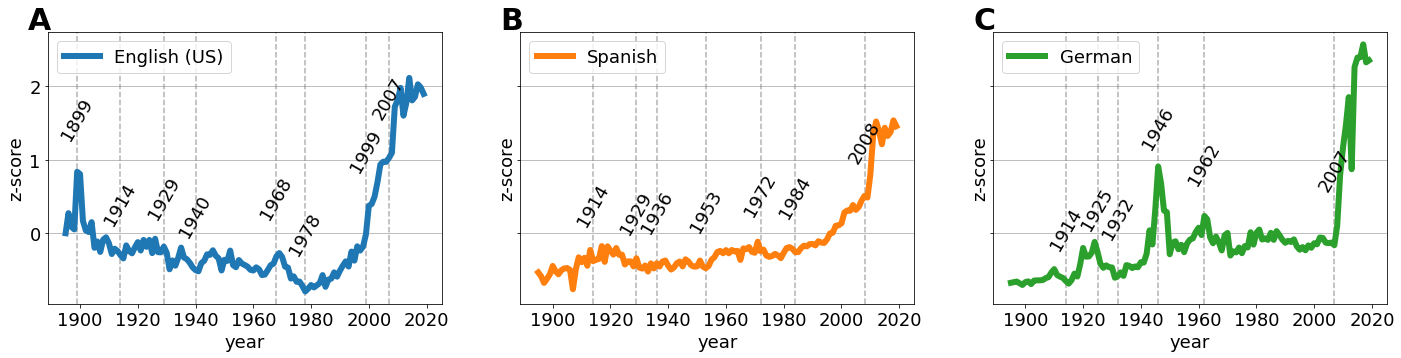

In [7]:
highlights = {
    "eng-us": [1899, 1914, 1929, 1940, 1968, 1978, 1999, 2007],
    "spa": [1914, 1929, 1936, 1953, 1972, 1984, 2008],
    "ger": [1914, 1925, 1932, 1946, 1962, 2007]
}

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(24, 5), sharey="all")

for i, lang in enumerate(_LANGS):
    
    for year in highlights[lang]:
        axs[i].axvline(x=year, alpha=0.6, color="tab:gray", ls="--")
        
        axs[i].text(year, lngz[lang].median(axis=1)[year + 1] + 0.75, str(year),
                    fontdict={'ha': 'center', 'va': 'center', 'bbox': None, 'size': 18}, rotation=60)
        
    axs[i].plot(lngz[lang].index, lngz[lang].median(axis=1), lw=6, color=_COLORS[lang], label=_LABELS[lang])
    
    axs[i].xaxis.set_ticks(range(1900,2040,20))
    axs[i].grid(b=True, which='major', axis='y')
    axs[i].legend(loc="upper left", fontsize=18)
    axs[i].set_xlabel("year", fontsize=18)
    axs[i].set_ylabel("z-score", fontsize=18)
    axs[i].tick_params(labelsize=18)
    
    axs[i].text(-0.05, 1.01, string.ascii_uppercase[i], transform=axs[i].transAxes, 
            size=30, weight='bold')
    
fig.savefig(_FIGPATH + "Figure2.pdf", dpi=600, 
            facecolor='w', edgecolor='w', orientation='landscape', papertype=None, format=None,
            transparent=False, bbox_inches=None, pad_inches=0.1, frameon=None, metadata=None)

# Figure 3

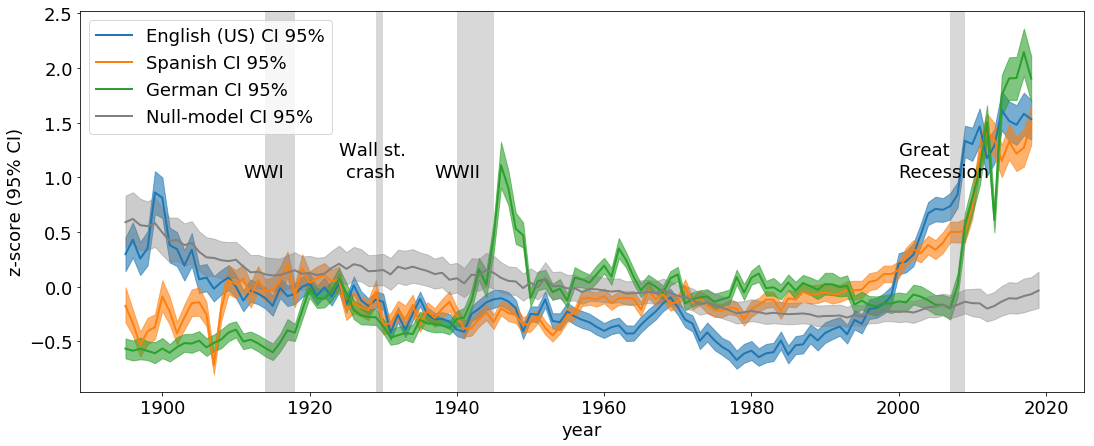

In [8]:
Nb = 10000 # bootstrap N

fig = plt.figure(figsize=(18, 7))
ax = fig.add_subplot(111)

for i, lang in enumerate(_LANGS):
    
    # create dataframe to retain bootstrap results
    btp = pd.DataFrame(index=pd.RangeIndex(start=1500, stop=2019, name="date"), 
                       columns=pd.RangeIndex(stop=Nb))
    
    # bootstrap sample of CDs x Nb, store mean of bootstrap distribution
    for i in range(Nb):
        # choice random column names with replacement
        resample = np.random.choice(lngz[lang].columns, size=len(lngz[lang].columns))
        
        # calculate mean for this random set of columns
        btp[i] = lngz[lang][resample].mean(axis=1)
    
    # plot CI and 50p line
    ax.fill_between(btp.index, btp.quantile(q=0.025, axis=1), btp.quantile(q=0.975, axis=1),
                    alpha=0.6, color=_COLORS[lang])
    btp.quantile(q=0.50, axis=1).plot(linewidth=2, color=_COLORS[lang], ax=ax,
                                      label="{} CI 95%".format(_LABELS[lang]))

brz.tail(_PAST).median(axis=1).plot(linewidth=2, color="gray", ax=ax, label="Null-model CI 95%")

ax.fill_between(brz.index, brz.quantile(q=0.025, axis=1), brz.quantile(q=0.975, axis=1), alpha=0.4, color="gray")
    
ax.set_xlabel("year", fontsize=18)
ax.set_ylabel("z-score (95% CI)", fontsize=18)
ax.legend(loc="upper left", fontsize=18)

ax.axvspan(1914, 1918, color='tab:gray', alpha=0.3, lw=0)
ax.axvspan(1929, 1930, color='tab:gray', alpha=0.3, lw=0)
ax.axvspan(1940, 1945, color='tab:gray', alpha=0.3, lw=0)
ax.axvspan(2007, 2009, color='tab:gray', alpha=0.3, lw=0)

ax.annotate("WWI",(1911,1.0,), fontsize=18)
ax.annotate("Wall st.",(1924,1.2,), fontsize=18)
ax.annotate("crash",(1925,1.0,), fontsize=18)
ax.annotate("WWII",(1937,1.0,), fontsize=18)
ax.annotate("Great",(2000,1.2,), fontsize=18)
ax.annotate("Recession",(2000,1.0,), fontsize=18)
ax.tick_params(labelsize=18)

fig.savefig(_FIGPATH + "Figure3.pdf", dpi=600, 
            facecolor='w', edgecolor='w', orientation='landscape', papertype=None, format=None,
            transparent=False, bbox_inches=None, pad_inches=0.1, frameon=None, metadata=None)

# Figure 4

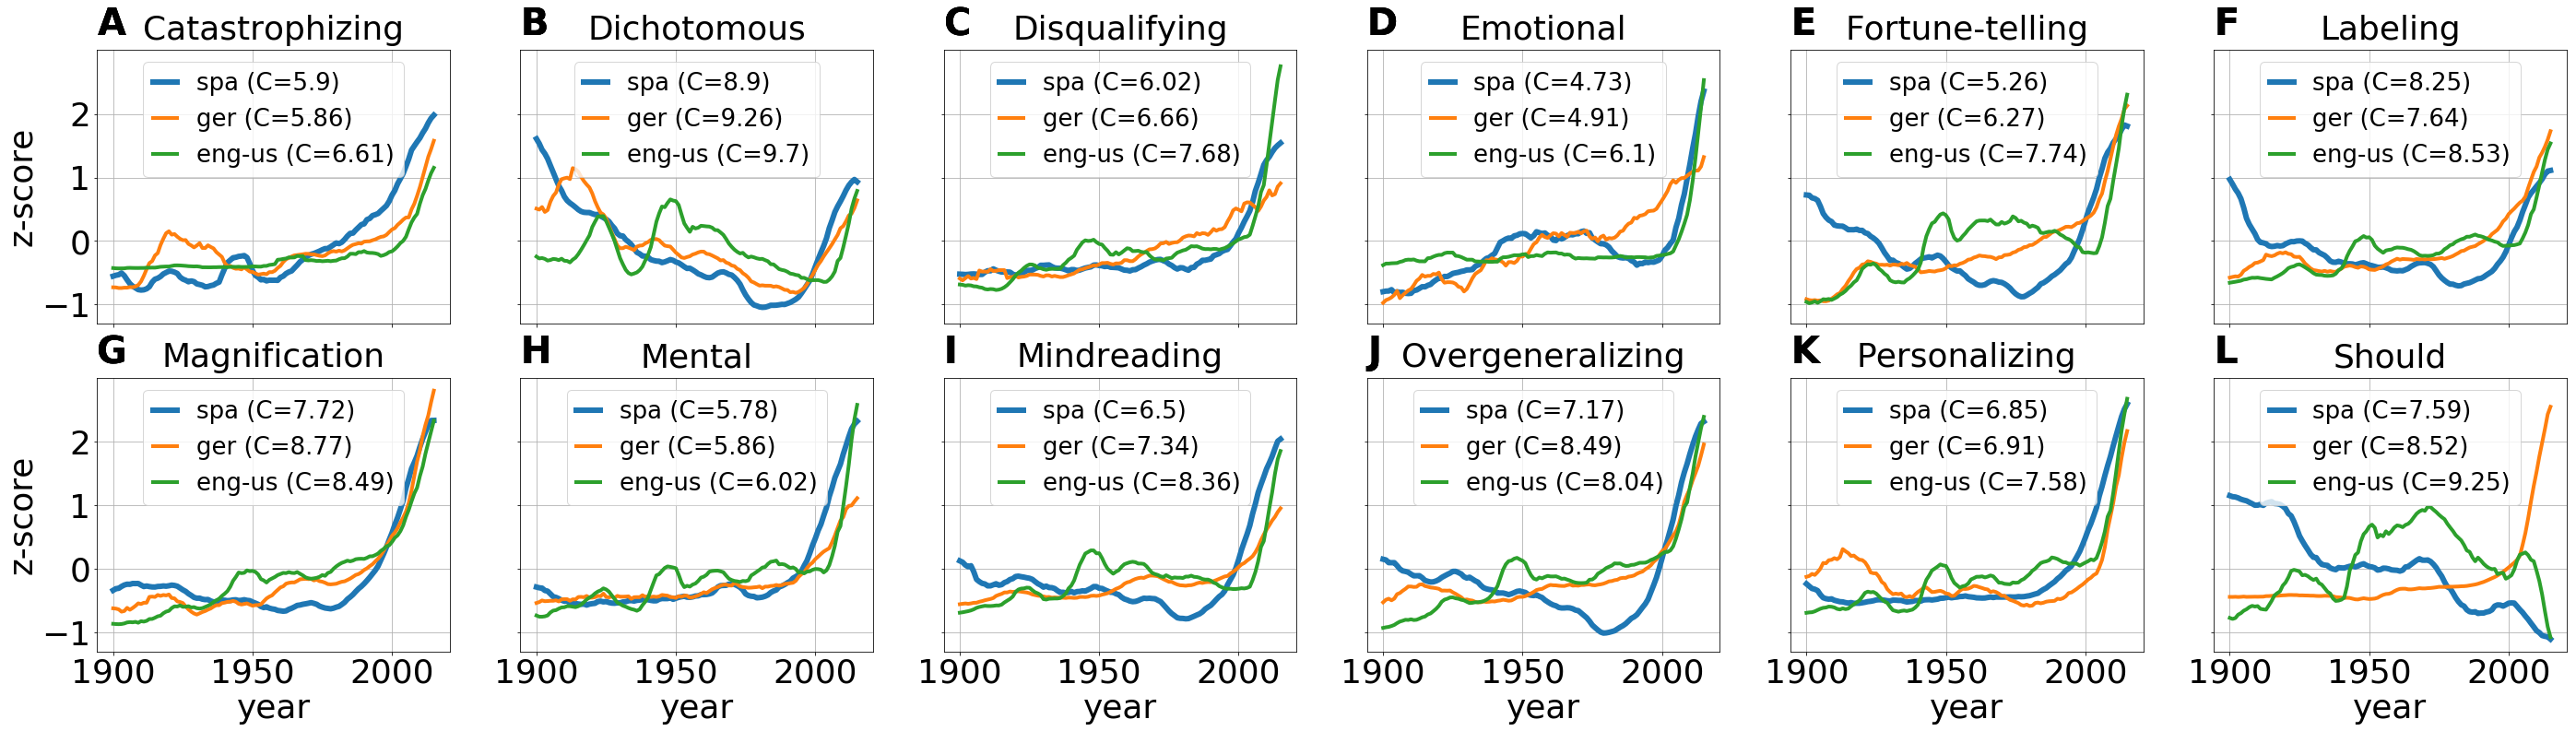

In [10]:
_CATS = ['Catastrophizing', 'Dichotomous Reasoning', 'Disqualifying the Positive', 'Emotional Reasoning',
         'Fortune-telling','Labeling and mislabeling', 'Magnification and Minimization', 'Mental Filtering',
            'Mindreading', 'Overgeneralizing', 'Personalizing', 'Should statements']
_CAT_LABELS = {
    'Catastrophizing': "Catastrophizing", 'Dichotomous Reasoning':'Dichot. Reason.',
    'Disqualifying the Positive': "Disqual. the pos.", 'Emotional Reasoning': "Emotional Reas.",
    'Fortune-telling': 'Fortune-telling','Labeling and mislabeling': 'Lab. & mislab.',
    'Magnification and Minimization': 'Magn. & Minimiz.', 'Mental Filtering': 'Mental Filtering',
    'Mindreading': 'Mindreading', 'Overgeneralizing': 'Overgeneralizing',
    'Personalizing': 'Personalizing', 'Should statements': 'Should statem.'
}

magnitude = {"spa":[], "ger":[], "eng-us":[]}
for i, t in enumerate(_CATS):
    for LANG in _LANGS:
        types = ngramtypes[LANG].groupby("CDtype").groups
        CDs_of_type_t = list(ngramtypes[LANG]["CDS"][list(types[t])].drop_duplicates())
        CDs_of_type_ngrams = list(ngramtypes[LANG]["CD"][list(types[t])].drop_duplicates())

        total = (t,lngf[LANG][CDs_of_type_ngrams].tail(_PAST).sum(axis=1).sum())
        if magnitude.get(LANG):
            magnitude[LANG] = magnitude[LANG] + [total]
        else:
            magnitude[LANG] = [total]

lang_prev_CDStype = {}
for LANG in _LANGS:
    s = sum([prev for CD,prev in magnitude[LANG]])
    prev_data = [(round(np.log10(prev),2),CD) for CD,prev  in magnitude[LANG]]
    prev_data_sorted = sorted(prev_data, reverse=True)
    lang_prev_CDStype[LANG] = dict([(CDtype,N) for N,CDtype in prev_data_sorted])

fig, axs = plt.subplots(nrows=2, ncols=6, figsize=(48, 12), sharex=True, sharey=True)

# loop through types, make separate graph for each with eng-us, spa, and ger z-scores
for i, t in enumerate(_CATS):
    ax = axs[i // 6, i % 6]

    ax.xaxis.set_major_locator(mticker.MultipleLocator(50))
    ax.yaxis.set_major_locator(mticker.MultipleLocator(1))
    ax.set_yticks([-1,0,1,2])
    
    for lang in _LANGS:
        lw = 6 if lang == "eng-us" else 4 # stress English with greater linewidth

        # use ngramtypes dataframe to plot by CDtypes
        types = ngramtypes[lang].groupby("CDtype").groups
        CDs_of_type_t = ngramtypes[lang]["CDS"][list(types[t])].drop_duplicates().values
        
        ax.plot(lngz[lang][CDs_of_type_t].median(axis=1).rolling(window=10,center=True).mean(), 
                lw=lw, label=_LABELS[LANG], color=_COLORS[lang])
        ax.grid(True, which="both")
        ax.tick_params(labelsize=36)
        
        # need to add CDS type as title to graph but some are too long
        # only use first word
        ax.set_title(t.split(" ")[0], fontsize=36, loc="center", pad=12)
        ax.text(0, 1.055, string.ascii_uppercase[i], transform=ax.transAxes, size=40, weight='bold')
        
    # add order of magnitude of summed raw frequencies for all n-grams in category to graph (see above cell)
    ax.legend(["spa (C="+str(lang_prev_CDStype["spa"][t])+")",\
               "ger (C="+str(lang_prev_CDStype["ger"][t])+")",\
               "eng-us (C="+str(lang_prev_CDStype["eng-us"][t])+")"],\
              fontsize=26, loc="upper center", handlelength=1)
        
    if i % 6 == 0:
        ax.set_ylabel("z-score", fontsize=36)

    if i // 6 == 1:
        ax.set_xlabel("year", fontsize=36)


fig.savefig(_FIGPATH + "Figure4.pdf", dpi=600, 
            facecolor='w', edgecolor='w', orientation='landscape', format=None,
            transparent=False, bbox_inches=None, pad_inches=0.1, metadata=None)

# Figure S1

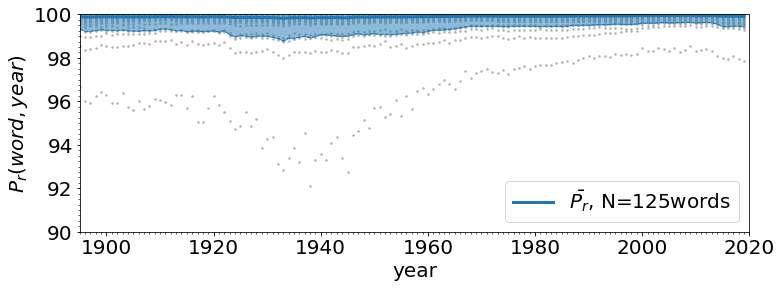

In [12]:
def extract_val(value):
    return float(value.split(",")[-1])

cols = pd.RangeIndex(start=1895, stop=2020)
df = pd.read_csv("CDS_individual_words_yearly_percentiles.tsv", sep="\t", header=None, index_col=0)
df2 = df[df.index.str.lower() == df.index]
dfl = df2.applymap(lambda x: extract_val(str(x)))
dfl.columns = cols

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(111)

dfl.mean().plot(legend=False, color="C0", linewidth=3, ax=ax, label=r"$\bar{P_r}$, N=125words", zorder=2)

for t in dfl.index:
    ax.plot(cols, dfl.loc[t, :], lw=0, ms=3, color="0.7", marker=".", zorder=1, label="")

dfl.quantile(q=0.025).plot(lw=1, color="C0", linestyle="--", ax=ax, label="", zorder=2)
dfl.quantile(q=0.975).plot(lw=1, color="C0", linestyle="--", ax=ax, label="", zorder=2)

ax.fill_between(cols, dfl.quantile(q=0.025), dfl.quantile(q=0.975), color="C0", alpha=0.5, zorder=2)
ax.set_xlabel("year", fontsize=20)
ax.set_ylabel(r"$P_r(word,year)$", fontsize=20)
ax.legend(loc="lower right", fontsize=20)
ax.tick_params(labelsize=20)
ax.set_xlim(1895, 2020)
ax.xaxis.set_major_locator(mticker.MultipleLocator(20))
ax.xaxis.set_minor_locator(mticker.MultipleLocator())
ax.set_ylim(90, 100)
ax.yaxis.set_major_locator(mticker.MultipleLocator(2))
ax.yaxis.set_minor_locator(mticker.MultipleLocator(0.25))

fig.savefig(_FIGPATH + "FigureS1.pdf", dpi=600, 
            facecolor='w', edgecolor='w', orientation='landscape', format=None,
            transparent=False, bbox_inches=None, pad_inches=0.1, metadata=None)

# Figure S2

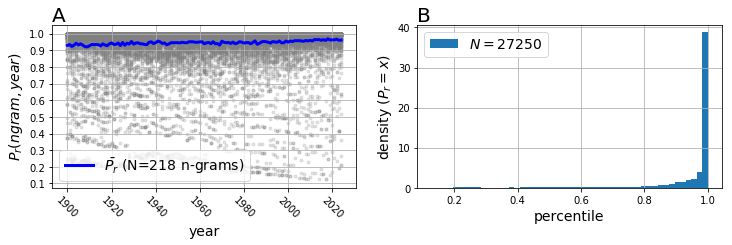

In [13]:
fig, axarr = plt.subplots(1, 2, figsize=(12, 3))

for c in perc_allngrams.columns:
    axarr[0].scatter(perc_allngrams.index, perc_allngrams[c], color="gray", alpha=0.2, marker=".",label="")
    
    
axarr[0].plot(perc_allngrams.mean(axis=1), linewidth=3, color="blue", label=r"$\bar{P_r}$ (N=218 n-grams)")

axarr[0].yaxis.set_minor_locator(mticker.MultipleLocator(5))
axarr[0].yaxis.set_major_locator(mticker.MultipleLocator(0.1))
axarr[0].yaxis.set_major_formatter(mticker.ScalarFormatter())
axarr[0].yaxis.set_minor_formatter(mticker.NullFormatter())
axarr[0].yaxis.set_minor_locator(mticker.MultipleLocator(0.1))
axarr[0].xaxis.set_major_locator(mticker.MultipleLocator(20))

axarr[0].set_xlabel("year", fontsize=14)
axarr[0].set_ylabel(r"$P_r (ngram,year)$", fontsize=14)
axarr[0].legend(loc="lower left", fontsize=14)

axarr[0].set_xticklabels(range(1880,2040,20), rotation=-45)
axarr[0].grid(b=True, which='major')
axarr[0].text(0, 1.02, "A", transform=axarr[0].transAxes, size=20)

Npr = str(len(perc_allngrams.values.flatten()))

axarr[1].hist(perc_allngrams.values.flatten(), bins=50, density=True, label=r'$N='+Npr+"$")
axarr[1].set_xlabel("percentile", fontsize=14)
axarr[1].set_ylabel(r"density $(P_r=x)$", fontsize=14)
axarr[1].legend(fontsize=14)
axarr[1].grid()
axarr[1].text(0, 1.02, "B", transform=axarr[1].transAxes, size=20)

fig.savefig(_FIGPATH + "FigureS2.pdf", dpi=600, 
            facecolor='w', edgecolor='w', orientation='landscape', format=None,
            transparent=False, bbox_inches=None, pad_inches=0.1, metadata=None)

# Figure S3

('50% reached at',          books
1982  0.499004)


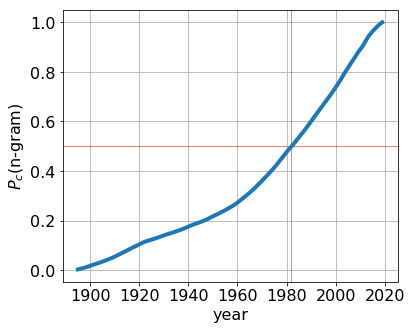

In [14]:
files = ["results_eng-us/totalcounts_eng-us_1.tsv", "results_eng-us/totalcounts_eng-us_2.tsv",
         "results_eng-us/totalcounts_eng-us_3.tsv", "results_eng-us/totalcounts_eng-us_4.tsv",
         "results_eng-us/totalcounts_eng-us_5.tsv"]

total_books = {}
for i, file in enumerate(files): 
    with open(file, "r") as f:
        d = f.readlines()
        # just 1 line
        #totals:eng-us_1 1472,116156,894,1       1475,328918,1162,1
        values = d[0].strip().split("\t")[1:]
        values = [v.split(",") for v in values]

        total=[]
        for year, match_count, page_count, volume_count in values:
            total.append((int(year),int(volume_count)))
    
    total_books[str(i+1)+"gram"] = dict(total)

# we only need 1-grams totalcounts (same books, right?)
books = pd.DataFrame({"books":total_books["1gram"]})
pbooks = books.tail(125)/books.tail(125).sum() # year's proportion of books vs published total in last 125 years

# where's the 50% line?
pbooks_cumsum = pbooks.cumsum()
print("50% reached at",pbooks_cumsum[(pbooks_cumsum>0.49) & (pbooks_cumsum<0.51)].dropna())


fig = plt.figure(figsize=(6, 5))
ax = fig.add_subplot(111)

ax.axhline(0.5, color="red",linewidth=1, alpha=0.5)
ax.axvline(1982, color="red",linewidth=1, alpha=0.5)
pbooks.cumsum().plot(ax=ax, lw=4, legend=None)

ax.xaxis.set_major_locator(mticker.MultipleLocator(20))
ax.yaxis.set_major_formatter(mticker.ScalarFormatter())
ax.yaxis.set_minor_formatter(mticker.NullFormatter())

ax.set_xlabel("year", fontsize=16)
ax.set_ylabel(r"$P_c($n-gram$)$", fontsize=16)
ax.tick_params(labelsize=16)
ax.grid(which="both")


fig.savefig(_FIGPATH + "FigureS3.pdf", dpi=600, 
            facecolor='w', edgecolor='w', orientation='landscape', format=None,
            transparent=False, bbox_inches=None, pad_inches=0.1, metadata=None)

# Figure S4

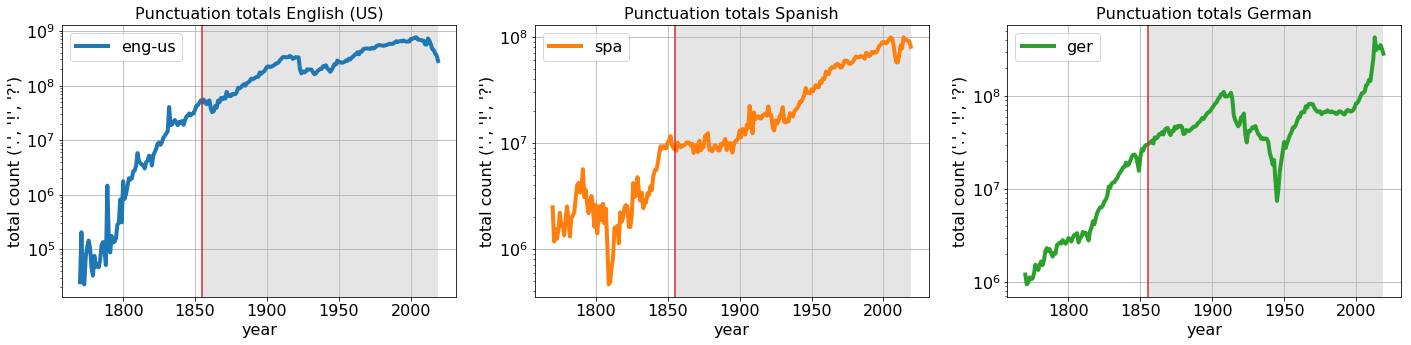

In [15]:
fig, axarr = plt.subplots(1, 3, figsize=(24, 5))

for i, lang in enumerate(_LANGS):
    punc_total_data = lngf[lang][lang+"_."] + lngf[lang][lang+"_!"] + lngf[lang][lang+"_?"]

    ax = axarr[i]
    ax.plot(punc_total_data.tail(250), linewidth=4, color=_COLORS[lang], label=lang)
    ax.axvspan(1855,2019, color='tab:gray', alpha=0.2, lw=0)

    ax.set_yscale("log")
    ax.set_title("Punctuation totals " + _LABELS[lang], fontsize=16)
    ax.set_xlabel("year", fontsize=16)
    ax.axvline(x=1855, color="tab:red", linestyle="-")
    ax.grid()
    ax.set_ylabel("total count ('.', '!', '?')", fontsize=16)
    ax.tick_params(labelsize=16)
    ax.legend(fontsize=16)

fig.savefig(_FIGPATH + "FigureS4.pdf", dpi=600, 
            facecolor='w', edgecolor='w', orientation='landscape', format=None,
            transparent=False, bbox_inches=None, pad_inches=0.1, metadata=None)

# Figure S5

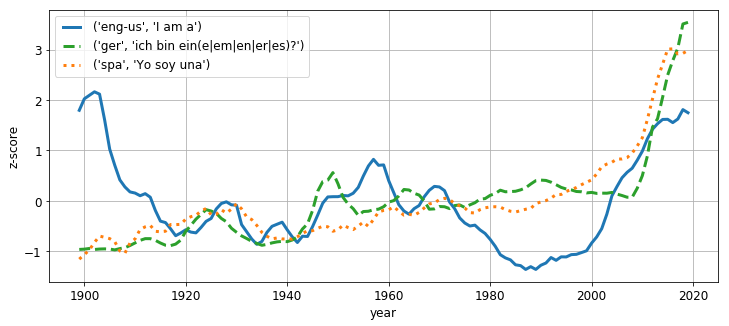

In [16]:
fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(111)

examples = [("eng-us", "I am a"), ("ger", "ich bin ein(e|em|en|er|es)?"), ("spa", "Yo soy una")]

data = lngz.tail(_PAST).rolling(5).mean()
linestyles = ['solid', 'dashed', 'dotted']

for i, ls in enumerate(linestyles):
    ex = examples[i]
    ax.plot(data.index, data[ex], lw=3, ls=ls, label=ex, color=_COLORS[ex[0]])

ax.set_xlabel("year", fontsize=12)
ax.set_ylabel("z-score", fontsize=12)
ax.grid()
ax.legend(loc="upper left", fontsize=12, numpoints=3)
ax.tick_params(labelsize=12)

fig.savefig(_FIGPATH + "FigureS5.pdf", dpi=600, 
            facecolor='w', edgecolor='w', orientation='landscape', format=None,
            transparent=False, bbox_inches=None, pad_inches=0.1, metadata=None)

# Figure S6

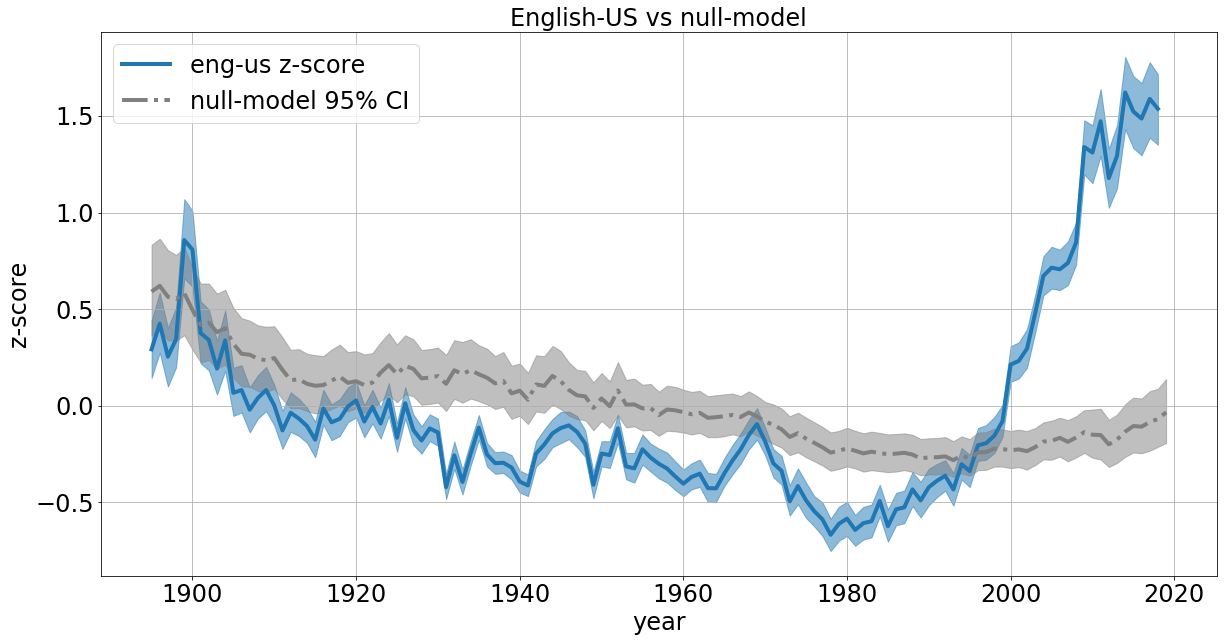

In [18]:
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(111)

Nb = 1000

# create dataframe to retain bootstrap results
bz = pd.DataFrame(index=pd.RangeIndex(start=1500, stop=2019, name="date"), 
                   columns=pd.RangeIndex(stop=Nb))

# bootstrap sample of CDs x Nb, store mean of bootstrap distribution
for i in range(Nb):
    # choice random column names with replacement
    resample = np.random.choice(lngz["eng-us"].columns, size=len(lngz["eng-us"].columns))

    # calculate mean for this random set of columns
    bz[i] = lngz["eng-us"][resample].mean(axis=1)

bz.tail(125).median(axis=1).plot(label="eng-us z-score", linewidth=4, ax=ax, color=_COLORS["eng-us"])
ax.fill_between(bz.index, bz.quantile(q=0.025, axis=1), bz.quantile(q=0.975, axis=1), 
                alpha=0.5, color=_COLORS["eng-us"])

    
brz.median(axis=1).plot(label="null-model 95% CI", linestyle="-.", linewidth=4, color="gray")
ax.fill_between(brz.index, brz.quantile(q=0.025, axis=1), brz.quantile(q=0.975, axis=1),
                alpha=0.5, color="gray")

ax.legend(loc="upper left", fontsize=24)
ax.set_xlabel("year", fontsize=24)
ax.set_ylabel("z-score", fontsize=24)
ax.set_title("English-US vs null-model", fontsize=24)
ax.tick_params(labelsize=24)
ax.grid()

fig.savefig(_FIGPATH + "FigureS6.pdf", dpi=600, 
            facecolor='w', edgecolor='w', orientation='landscape', format=None,
            transparent=False, bbox_inches=None, pad_inches=0.1, metadata=None)

# Figure S7

In [ ]:
fig, axarr = plt.subplots(1, 3, figsize=(24, 6), sharey=True)

for num, lang in enumerate(_LANGS):
    ax = axarr[num]
    
    ax.plot(lngz[lang].index, lngz[lang].tail(_PAST).rolling(3).mean(),
                     alpha=0.2, color="0.7", lw=0.1, marker=".", ms=4, rasterized=True)
    ax.plot(lngz[lang].index, lngz[lang].tail(_PAST).rolling(3).mean().median(axis=1),\
                    linewidth=5, color="black", label=_LABELS[lang], rasterized=True, marker='.')
    
    ax.set_xticklabels(range(1880,2040,20), rotation=-45)
    ax.grid()
    ax.tick_params(labelsize=18)
    ax.legend(loc="upper left", fontsize=18)
    ax.set_xlabel("year", fontsize=18)
    ax.set_ylabel("z-score", fontsize=18)


fig.savefig(_FIGPATH + "FigureS7.pdf", dpi=600, 
            facecolor='w', edgecolor='w', orientation='landscape', format=None,
            transparent=False, bbox_inches=None, pad_inches=0.1, metadata=None)